# Select contour for circum-Antarctic isobath using a mask

This script:
1. Finds a depth contour on the edge of the u-grid and on the centre of the t-grid - 
   e.g. all points closest to Antarctica with depth <= 1000m (or any other depth). Note the u-grid and t-grid cells might not be the same.
    The points need to be connected.
2. Manually cleans up any messy closed loops etc in contour.
3. Allows for smoothing of the isobath prior to the contour selection.

Script is based on `find_depth_contour_fromAdele.ipynb` from Adele Morrison. 

Isobaths using this method used in ASC spatial and temporal variability project:
- 2000 m isobath contour: for selection of cross-slope transects when creating the continental slope coordinate system.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean as cm
import glob
import matplotlib.colors as col
# need to install opencv-python for this script to work:
# pip install opencv-python --user
# check if it is installed: 
# pip list
import cv2

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/x77/wgh581/Figures/'

Dask client

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36433 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


Database and experiment

In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
exp = '01deg_jra55v13_ryf9091'

Selection of latitude range, contour depth, u-grid or t-grid, smoothing (change this according to your purpose)

In [46]:
# Latitude range
lat_range = slice(-90,-59)
# Select contour depth
contour_depth = 630 # st_ocean nearest value is 571 m, 630.72 m
# u-grid (u) or t-grid (t)
grid_sel = 'u'
# Smooting (no 0, yes 1)
smoothing = 1

## Import bathymetry (and smooth)

In [47]:
# Function that smoothed the data in x and y direction
def running_mean_2d(in_data, N):
    in_data  = in_data.load()
    out_data = in_data.copy(deep=True)
    for yy in range(np.shape(in_data)[0]):
        cumsum_tmp = np.nancumsum(np.insert(in_data.values[yy,:], 0, 0))
        out_data[yy,int(N/2):-int(N/2)+1] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)  # works for smoothing over 10 grid cells
    for xx in range(np.shape(in_data)[1]):
        cumsum_tmp = np.nancumsum(np.insert(in_data.values[:,xx], 0, 0))
        out_data[int(N/2):-int(N/2)+1,xx] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    return out_data

In [48]:
# Load lat/lon information
yt_ocean = cc.querying.getvar(exp, 'yt_ocean', session, n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(exp, 'yu_ocean', session, n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(exp, 'xt_ocean', session, n=1)
xu_ocean = cc.querying.getvar(exp, 'xu_ocean', session, n=1)

# Load bathymetry
if grid_sel == 'u':
    h = cc.querying.getvar(exp, 'hu', session, n=1)
    h = h.sel(yu_ocean=lat_range)
elif grid_sel == 't':
    h = cc.querying.getvar(exp, 'ht', session, n=1)
    h = h.sel(yt_ocean=lat_range)

# Smoothing of bathymetry
if smoothing == 1:
    h = running_mean_2d(h, 10)

# Fill in land with zeros:
h = h.fillna(0)

# Create a mask that knows of the contour depth
tmp_mask = np.copy(h)
tmp_mask[np.where(h >  contour_depth)] = 0
tmp_mask[np.where(h <= contour_depth)] = 1
#tmp_mask[np.where(h >= contour_depth)] = 0
#tmp_mask[np.where(h <  contour_depth)] = 1

In [49]:
if grid_sel == 'u':
    x_var = xu_ocean
    y_var = yu_ocean
elif grid_sel == 't':
    x_var = xt_ocean
    y_var = yt_ocean

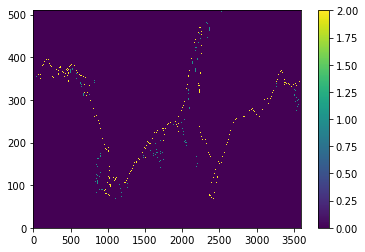

In [50]:
fig = plt.figure()
#plt.pcolormesh(tmp_mask)

plt.pcolormesh(contour_mask0)
plt.colorbar()

## Find depth contours

In [51]:
# This spreads the isobath contour so all points are connected adjacently (not just diagonally):
kernel = np.ones((3,3),np.uint8)
contour_mask0 = cv2.dilate(tmp_mask, kernel, iterations=1) - tmp_mask

# Start at western edge of domain, at y point closest to correct depth contour:
contour_mask = np.zeros_like(h)
if contour_depth in(1500, 2000, 2500):
    # pick most southerly contour:
    contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][0]
else:
    # pick most northerly contour:
    contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][-1]
contour_mask[contour_lat_index_start,0] = 1

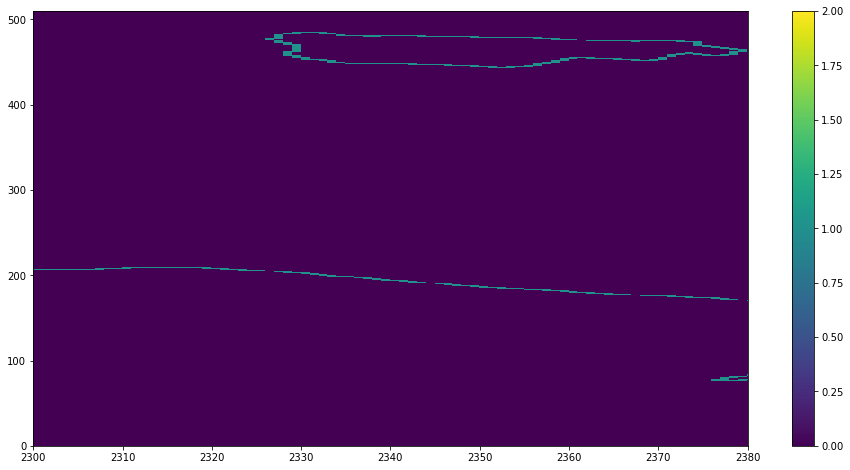

In [52]:
# In case you want to check what contour_mask0 looks like, e.g. is it continuous around Antarctica?
plt.figure(1, figsize=(16,8))
plt.pcolormesh(contour_mask0)
plt.colorbar()
plt.clim((0,2))
plt.xlim((2300, 2380));
#plt.xlim((400,800))
#plt.ylim((350,450));

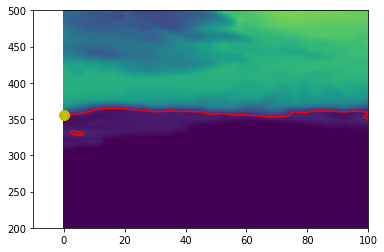

In [53]:
# plot to make sure contour_lat_index_start (yellow dot) is on the correct contour:

plt.pcolormesh(h)
plt.contour(h, [contour_depth], colors='r')
plt.xlim((-10,100))
plt.ylim((200,500))
plt.plot(0, contour_lat_index_start, 'yo', markersize=10)

## Select out only the contour we want

In [54]:
# Loop through to find adjacent point closest to isobath depth (not including previous point):
last_index_i = 0
last_index_j = contour_lat_index_start
count = 0
while last_index_i < h.shape[1]-1:
    # print(last_index_i)
    # first time don't go backwards:
    if last_index_i == 0:
        points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
            0,
            contour_mask0[last_index_j+1,last_index_i],
            contour_mask0[last_index_j-1,last_index_i]])
    else:
        points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
            contour_mask0[last_index_j,last_index_i-1],
            contour_mask0[last_index_j+1,last_index_i],
            contour_mask0[last_index_j-1,last_index_i]])

    new_loc = np.where(points_to_compare==1)[0]

    # this gives each point along contour a unique index number:
    if len(new_loc)==0:
        contour_mask[last_index_j,last_index_i] = 0
        contour_mask0[last_index_j,last_index_i] = 0
        #contour_mask0[contour_mask==count] = 0
        #print('j'+str(last_index_j)+'i'+str(last_index_i))
        count = count - 1
        last_index_i = np.where(contour_mask==count+1)[1]
        last_index_j = np.where(contour_mask==count+1)[0]
        continue
    elif len(new_loc)>0:
        if new_loc[0] == 0:
            new_index_i = last_index_i+1
            new_index_j = last_index_j
        elif new_loc[0] == 1:
            new_index_i = last_index_i-1
            new_index_j = last_index_j
        elif new_loc[0] == 2:
            new_index_i = last_index_i
            new_index_j = last_index_j+1
        elif new_loc[0] == 3:
            new_index_i = last_index_i
            new_index_j = last_index_j-1
        contour_mask[new_index_j,new_index_i] = count + 2
        contour_mask0[last_index_j,last_index_i] = 2
        last_index_j = new_index_j
        last_index_i = new_index_i
        count += 1

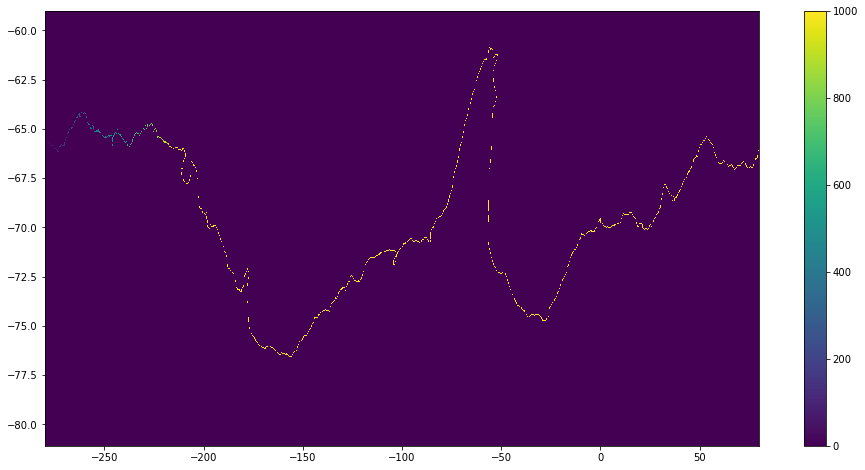

In [55]:
# check what contour_mask looks like, is it continuous around Antarctica?

plt.figure(1, figsize=(16,8))
plt.pcolormesh(x_var, y_var, contour_mask)
plt.colorbar()
plt.clim((0,1000))
#plt.xlim((-280,-220))
#plt.ylim((-68,-62));

## Manually edit out any extraneous loops

THIS SECTION CAN BE SKIPPED IF NOT INTERESTED IN THE CROSS-SLOPE TRANSPORT.

(Useful when interested in calculating cross-slope transport: remove loops that won't contribute to the cross-slope transport anyway)

In [164]:
# just need to remove loops, not double thickness contour or small indents:

# 650m and 800m didn't need editing between -280 and -220 longitude

# for access-om2-01 bathymetry only:
if contour_depth ==1000:
    contour_mask[(contour_mask>1656)&(contour_mask<1662)] = 0
    contour_mask[223,1019] = 1657
    contour_mask[contour_mask>1661] -= 4
    contour_mask[(contour_mask>3374)&(contour_mask<3380)] = 0
    contour_mask[430,2170] = 3375
    contour_mask[contour_mask>3375] -= 4
    
if contour_depth ==1500:
    contour_mask[(contour_mask>632)&(contour_mask<639)] = 0
    contour_mask[contour_mask>=639] -= 6
    
if contour_depth ==2500:
    contour_mask[(contour_mask>895)&(contour_mask<901)] = 0
    contour_mask[380,453] = 896
    contour_mask[contour_mask>=901] -= 4
    contour_mask[(contour_mask>1085)&(contour_mask<1102)] = 0
    contour_mask[contour_mask>=1102] -= 16
    contour_mask[(contour_mask>1173)&(contour_mask<1180)] = 0
    contour_mask[contour_mask>=1180] -= 6


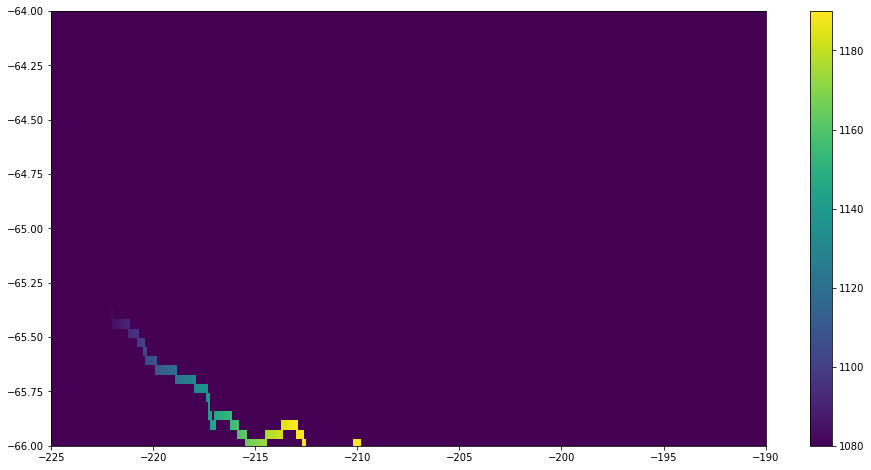

In [45]:
# to figure out where the loops are, manually run along each section of contour and inspect.
plt.figure(1,figsize=(16,8))
#plt.pcolormesh(x_var, y_var, orig, cmap=cm.cm.balance)
plt.pcolormesh(x_var, y_var, contour_mask)
#plt.pcolormesh(contour_mask)
plt.colorbar()
plt.clim((1080,1190))
#plt.xlim(140,200)
#plt.ylim(340,450);
plt.xlim((-225,-190))
plt.ylim((-66,-64));

## Create mask to separate points above contour from points below contour

In [56]:
contour_mask_numbered = contour_mask

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1,0] = -100

# from top left:
for ii in range(len(x_var)-1):
    for jj in range(len(y_var))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj-1,ii+1] == 0:
                contour_masked_above[jj-1,ii+1] = -100
# from top right:
for ii in range(len(x_var))[::-1][:-1]:
    for jj in range(len(y_var))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj-1,ii-1] == 0:
                contour_masked_above[jj-1,ii-1] = -100
# from bottom right:
for ii in range(len(x_var))[::-1][:-1]:
    for jj in range(len(y_var)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj+1,ii-1] == 0:
                contour_masked_above[jj+1,ii-1] = -100
# from bottom left:
for ii in range(len(x_var)-1):
    for jj in range(len(y_var)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj+1,ii+1] == 0:
                contour_masked_above[jj+1,ii+1] = -100


(300.0, 500.0)

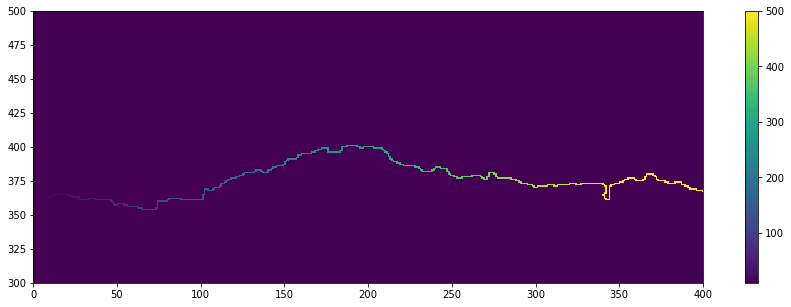

In [57]:
fig = plt.figure(figsize=(15,5))
plt.pcolormesh(contour_mask_numbered)
plt.colorbar()
plt.clim(10,500)
plt.xlim(0, 400)
plt.ylim(300, 500)

## A few useful information

In [58]:
# Number of grid points on the contour
num_points = np.count_nonzero(contour_mask_numbered)

In [59]:
np.shape(h)

(510, 3600)

In [68]:
# lat and lon along the contour
lat_along_contour = np.zeros((num_points))
lon_along_contour = np.zeros((num_points))
h_along_contour = np.zeros((num_points))

indices_masked = np.stack(contour_mask_numbered)
indices = np.sort(indices_masked[indices_masked>0])
for count in indices:
    count = int(count)
    jj = int(np.where(contour_mask_numbered==count)[0])
    ii = int(np.where(contour_mask_numbered==count)[1])
    lon_along_contour[count-1] = x_var[ii].values
    lat_along_contour[count-1] = y_var[jj].values
    h_along_contour[count-1] = h[jj, ii]

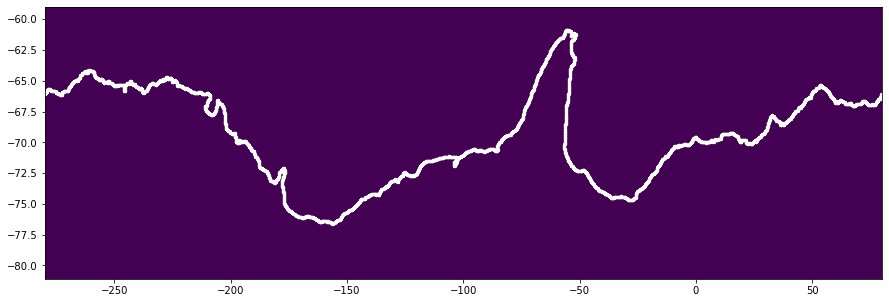

In [61]:
# Test that the lon/lat values are correct
fig = plt.figure(figsize=(15,5))
plt.pcolormesh(x_var, y_var, contour_mask_numbered)
plt.scatter(lon_along_contour, lat_along_contour, color='w', s=5)
#plt.xlim(-60,-40)
#plt.ylim(-68,-62);

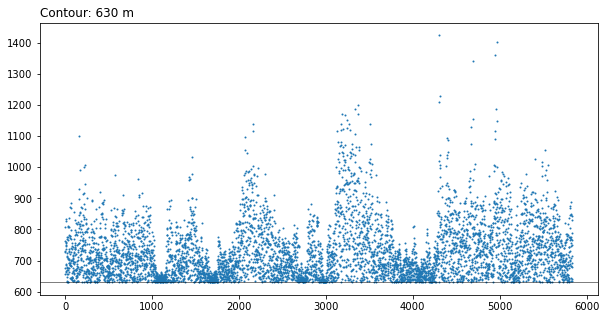

In [74]:
fig = plt.figure(figsize=(10,5))
plt.plot(h_along_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5)
plt.title('Contour: %i m'%contour_depth, loc='left');

To get the distance along the contour, we need to first calculate the x and y contributions.

Create masks for x and y transport calculations (i.e. determine if positive u and v will be into or out of contour)

In [29]:
# separate out points on isobath that will correspond to zonal or meridional transport
# across contour (i.e. depending on localshape of contour):

# make masks to multiply x and y transports at correct places:
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)
# make halos:
contour_masked_above_halo = np.zeros((contour_masked_above.shape[0],
    contour_masked_above.shape[1]+2))
contour_masked_above_halo[:,0] = contour_masked_above[:,-1]
contour_masked_above_halo[:,1:-1] = contour_masked_above
contour_masked_above_halo[:,-1] = contour_masked_above[:,0]

new_number_count = 1
for mask_loc in range(1,int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1,index_i]==0) and (contour_masked_above[index_j-1,index_i]!=0):
        mask_y_transport[index_j,index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j,index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1,index_i]==0) and (contour_masked_above[index_j+1,index_i]!=0):
        mask_y_transport[index_j-1,index_i] = 1
        mask_y_transport_numbered[index_j-1,index_i] = new_number_count
        new_number_count += 1
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j,index_i+2]==0) and (contour_masked_above_halo[index_j,index_i]!=0):
        mask_x_transport[index_j,index_i] = -1
        mask_x_transport_numbered[index_j,index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j,index_i]==0) and (contour_masked_above_halo[index_j,index_i+2]!=0):
        mask_x_transport[index_j,index_i-1] = 1
        mask_x_transport_numbered[index_j,index_i-1] = new_number_count
        new_number_count += 1

In [30]:
# extract dxt/dyt along contour:
north_index = 510
grid_file2 = '/g/data/v45/akm157/model_data/mom01_unmasked_ocean_grid.nc'
gridFile = nc.Dataset(grid_file2)
dxu = gridFile.variables['dxu'][...]
dyt = gridFile.variables['dyt'][:north_index,:]

distance_along_contour = np.zeros((num_points))
x_indices = np.sort(mask_x_transport_numbered[mask_x_transport_numbered>0])
y_indices = np.sort(mask_y_transport_numbered[mask_y_transport_numbered>0])
skip = False
for count in range(1,num_points):
    if skip == True:
        skip = False
        continue
    if count in y_indices:
        if count + 1 in y_indices:
            # note dxu and dyt do no vary in x (hence we can use the index 990 everywhere):
            jj = np.where(mask_y_transport_numbered==count)[0]
            distance_along_contour[count-1] = (dxu[jj,990])[0]
        else:
            jj0 = np.where(mask_y_transport_numbered==count)[0]
            jj1 = np.where(mask_x_transport_numbered==count+1)[0]
            if np.sum(jj1) == 0:
                print(count)
            if (contour_depth == 2500) & (count == 7368):#== 0: # if statement added by Wilma for 2500 m contour
                jj1 = np.where(mask_x_transport_numbered==count-1)[0]
            if (contour_depth == 650) & (count == 5984) & (grid_sel=='u'):#== 0: # if statement added by Wilma for 650 m contour
                jj1 = np.where(mask_x_transport_numbered==count-2)[0]
            diagonal_distance = 0.5*np.sqrt((dxu[jj0,990])[0]**2+\
                (dyt[jj1,990])[0]**2)
            distance_along_contour[count-1] = diagonal_distance
            distance_along_contour[count] = diagonal_distance
            # skip to next count:
            skip = True
    # count in x_indices:
    else:
        if count + 1 in x_indices:
            jj = np.where(mask_x_transport_numbered==count)[0]
            distance_along_contour[count-1] = (dyt[jj,990])[0]
        else:
            jj0 = np.where(mask_x_transport_numbered==count)[0]
            jj1 = np.where(mask_y_transport_numbered==count+1)[0]
            if np.sum(jj0) == 0: # if statement added by Wilma for 2500 m contour
                print('entered loop jj0')
                jj0 = np.where(mask_x_transport_numbered==count-3)[0]
            if np.sum(jj1) == 0: # if statement added by Wilma for 2500 m contour
                print('entered loop jj1')
                jj1 = np.where(mask_y_transport_numbered==count-2)[0]
                if count == 7677:
                    jj1 = np.where(mask_y_transport_numbered==count-4)[0]
            diagonal_distance = 0.5*np.sqrt((dyt[jj0,990])[0]**2+\
                (dxu[jj1,990])[0]**2)
            distance_along_contour[count-1] = diagonal_distance
            distance_along_contour[count] = diagonal_distance
            # skip to next count:
            skip = True
# fix last value:
if distance_along_contour[-1] == 0:
    count = count + 1
    if count in y_indices:
        jj = np.where(mask_y_transport_numbered==count)[0]
        distance_along_contour[-1] = (dxu[jj,990])[0]
    # commented below by Wilma for 2500 m contour
    #else:
    #    jj = np.where(mask_x_transport_numbered==count)[0]
    #    distance_along_contour[-1] = (dyt[jj,990])[0]

# units are 10^3 km:
distance_along_contour = np.cumsum(distance_along_contour)/1e3/1e3

## Save

Run the script for the u-grid and the t-grid and then save both together.

In [31]:
if grid_sel == 'u':
    contour_mask_numbered_u  = contour_mask_numbered
    contour_masked_above_u   = contour_masked_above
    num_points_u             = num_points
    lon_along_contour_u      = lon_along_contour
    lat_along_contour_u      = lat_along_contour
    distance_along_contour_u = distance_along_contour
elif grid_sel == 't':
    contour_mask_numbered_t  = contour_mask_numbered
    contour_masked_above_t   = contour_masked_above
    num_points_t             = num_points
    lon_along_contour_t      = lon_along_contour
    lat_along_contour_t      = lat_along_contour
    distance_along_contour_t = distance_along_contour

In [32]:
import os
save_dir = '/g/data/x77/wgh581/Post_Process/'
if smoothing == 0:
    outfile = os.path.join(save_dir,'Antarctic_slope_contour_u_t_'+str(contour_depth)+'m.npz')
elif smoothing == 1:
    outfile = os.path.join(save_dir,'Antarctic_slope_contour_smoothed_u_t_'+str(contour_depth)+'m.npz')

np.savez(outfile, contour_depth=contour_depth, 
    contour_mask_numbered_u=contour_mask_numbered_u, contour_masked_above_u=contour_masked_above_u, 
    contour_mask_numbered_t=contour_mask_numbered_t, contour_masked_above_t=contour_masked_above_t,
    xu_ocean=xu_ocean, yu_ocean=yu_ocean, xt_ocean=xt_ocean, yt_ocean=yt_ocean,
    num_points_u=num_points_u, num_points_t=num_points_t, 
    distance_along_contour_u=distance_along_contour_u, distance_along_contour_t=distance_along_contour_t,
    lon_along_contour_u=lon_along_contour_u, lat_along_contour_u=lat_along_contour_u,
    lon_along_contour_t=lon_along_contour_t, lat_along_contour_t=lat_along_contour_t)